<a href="https://colab.research.google.com/github/bkenan/CLIP/blob/main/Computer_Vision_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import urllib.request
import zipfile
import copy
import time
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap

In [ ]:
!pip install shap

In [ ]:
# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "cv_aix360" # Enter repo name
git_path = 'https://github.com/bkenan/cv_aix360.git'
!git clone "{git_path}"

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'cv_aix360' already exists and is not an empty directory.


In [ ]:
!cd /content/cv_aix360/

In [ ]:
data_dir = '/content/cv_aix360/data'

# Set up transformations for training and validation (test) data
# For training data we will do randomized cropping to get to 224 * 224, randomized horizontal flipping, and normalization
# For test set we will do only center cropping to get to 224 * 224 and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create Datasets for training and validation sets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          data_transforms['val'])

# Create DataLoaders for training and validation sets
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)

# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}

# Store size of training and validation sets
dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset)}
# Get class names associated with labels
class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([8, 3, 224, 224])


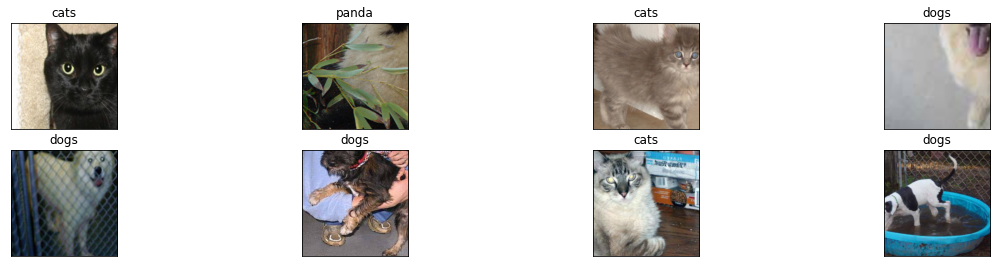

In [ ]:
# Visualize a batch of images
images, labels = iter(train_loader).next()
print(images.shape)
images = images.numpy()
fig = plt.figure(figsize=(20, 16))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(7, batch_size//2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title("{}".format(class_names[labels[idx]]))

In [ ]:
# Instantiate pre-trained resnet
net = torchvision.models.resnet152(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in net.parameters():
    param.requires_grad = False

# Display a summary of the layers of the model and output shape after each layer
summary(net,(images.shape[1:]),batch_size=batch_size,device="cpu")

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 112, 112]           9,408
       BatchNorm2d-2          [8, 64, 112, 112]             128
              ReLU-3          [8, 64, 112, 112]               0
         MaxPool2d-4            [8, 64, 56, 56]               0
            Conv2d-5            [8, 64, 56, 56]           4,096
       BatchNorm2d-6            [8, 64, 56, 56]             128
              ReLU-7            [8, 64, 56, 56]               0
            Conv2d-8            [8, 64, 56, 56]          36,864
       BatchNorm2d-9            [8, 64, 56, 56]             128
             ReLU-10            [8, 64, 56, 56]               0
           Conv2d-11           [8, 256, 56, 56]          16,384
      BatchNorm2d-12           [8, 256, 56, 56]             512
           Conv2d-13           [8, 256, 56, 56]          16,384
      BatchNorm2d-14           [8, 256,

In [ ]:
# Get the number of inputs to final Linear layer
num_ftrs = net.fc.in_features
# since we have 3 classes
net.fc = nn.Linear(num_ftrs, 3)

In [ ]:
# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs):
    model = model.to(device) # Send model to GPU if available
    
    iter_num = {'train':0,'val':0} # Track total number of iterations

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

                # Iterate count of iterations
                iter_num[phase] += 1

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


            # If model performs better on val set, save weights as the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:3f}'.format(best_acc))

    # Load the weights from best model
    model.load_state_dict(best_model_wts)

    return model

In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the model
net = train_model(net, criterion, optimizer, dataloaders, device, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.3222 Acc: 0.8733
val Loss: 0.0421 Acc: 0.9844

Epoch 1/9
----------
train Loss: 0.2307 Acc: 0.9129
val Loss: 0.0440 Acc: 0.9844

Epoch 2/9
----------
train Loss: 0.2074 Acc: 0.9153
val Loss: 0.0644 Acc: 0.9822

Epoch 3/9
----------
train Loss: 0.1967 Acc: 0.9216
val Loss: 0.0399 Acc: 0.9911

Epoch 4/9
----------
train Loss: 0.2046 Acc: 0.9247
val Loss: 0.0314 Acc: 0.9889

Epoch 5/9
----------
train Loss: 0.2294 Acc: 0.9110
val Loss: 0.0430 Acc: 0.9844

Epoch 6/9
----------
train Loss: 0.2007 Acc: 0.9267
val Loss: 0.0398 Acc: 0.9889

Epoch 7/9
----------
train Loss: 0.1798 Acc: 0.9345
val Loss: 0.0376 Acc: 0.9933

Epoch 8/9
----------
train Loss: 0.2390 Acc: 0.9173
val Loss: 0.0449 Acc: 0.9889

Epoch 9/9
----------
train Loss: 0.2170 Acc: 0.9271
val Loss: 0.0539 Acc: 0.9844

Training complete in 11m 16s
Best val Acc: 0.993333


In [ ]:
save_path = './resnet152.pth'
torch.save(net, save_path)

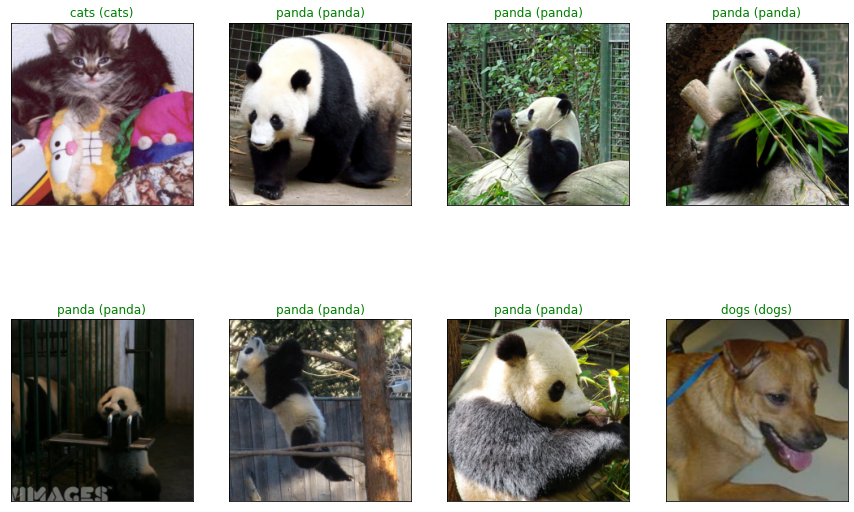

In [ ]:
# Display a batch of predictions
def visualize_results(model,dataloader,device):
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = iter(val_loader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(net,val_loader,device)

In [ ]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)

batch = next(iter(val_loader))
images, _ = batch

background = images[:100].to(device)
test_images = images[100:110].to(device)

In [ ]:
e = shap.DeepExplainer(net, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

In [ ]:
shap.image_plot(shap_numpy, -test_numpy)

UnboundLocalError: ignored

<Figure size 864x180 with 0 Axes>

In [ ]:
images[100:110]

tensor([], size=(0, 3, 224, 224))

In [ ]:
background = np.squeeze(background, axis=0)

In [ ]:
test_images = np.squeeze(test_images, axis=0)

In [ ]:
e = shap.DeepExplainer(net, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)